# Training a Lunar Lander to Safely Land with RL (30 points)

In this assignment, we will use RL to train a model to control a "Lunar Lander" in the OpenAI gym Environment.

Let's get started!

First, make sure that pytorch is installed in your python environment, using the guide in here https://pytorch.org/get-started/locally/. Instructions will vary depending on whether you are running torch from CPU or GPU. We recommend running this exercise on GPU if possible. After installing pytorch, restart the kernel of the jupyter notebook ("refresh" button above).

Then, we start by installing the necessary additonal packages, such as Gym.

In [1]:
import sys
!{sys.executable} -m pip install gym[box2d] pygame matplotlib

Let's then import all necessary packages.

In [2]:
import gym
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
from collections import deque

# For visualization
from IPython.display import clear_output, display

Now let's create the LunarLander-v2 environment and see how to operate on it. An environment has the following properties:

* **Action space** is the set of possible actions that we can perform at each step of the simulation
* **Observation space** is the space of observations that we can make

See https://www.gymlibrary.dev/environments/box2d/lunar_lander/ for a more complete description of the Lunar Lander environment.

In [3]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(4)
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)


Let's see how the simulation works. The following loop runs the simulation, until `env.step` returns `terminated` or `truncated`. We are now choosing random actions using `env.action_space.sample()`, which means the experiment will probably fail.

The total reward is attained by summing rewards at every step, according to the following rules:

> Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

Total reward: -113.1073400575257


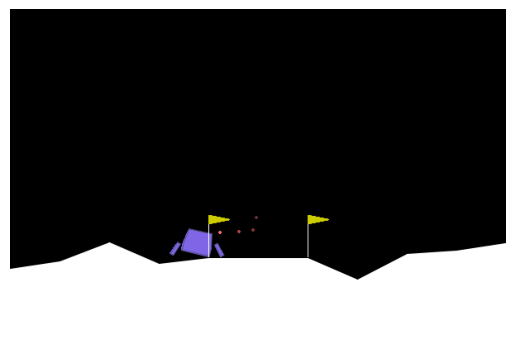

In [8]:
state = env.reset()
total_reward = 0
render = True
if render:
    img = plt.imshow(env.render())

while True:
    if render:
        img.set_data(env.render())
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break
print(f"Total reward: {total_reward}")

After a few seconds, you should see an output with the total reward achieved in this episode. Congratulations, your env is up and running!

### Task 2a (4 points)
Although total reward can quantify how good or bad the episode goes, it is hard to imagine what actually happens within the env. Therefore, it is important for us to visualize the episode.

Copy the code from the previous block into the following block, set `render` to `True` and run the code. Now you should be able to see a purple moon lander landing (or much more likely, crashing).

<font color='red'>**Please make a screen recording of the visualization and report on the final Total Reward output.**</font>

In [ ]:
#####
# COMPLETE CODE HERE



#####

The total reward is likely negative because the action is randomly sampled from the action space. During reinforcement learning, our goal is to train a **policy** $\pi$, that for each state $s$ will tell us which action $a$ to take, so essentially $a = \pi(s)$.

If you want probabilistic solution, you can think of policy as returning a set of probabilities for each action, i.e. $\pi(a|s)$ would mean a probability that we should take action $a$ at state $s$.

# Deep Q-Network

### Task 2b (8 points)

As seen in the class, a popular Reinforcement Learning algorithm is Q-learning, in which the "Q function" is approximated and used to define a policy. Specifically, we use a neural network to represent the Q function.

Since LunarLander-v2 environment is a simple environment, we don't need a complicated architecture. A simple feed-forward neural network will suffice.

<font color='red'>**Please complete the code to make a simple 3-layer network with hidden layer input and output size 64.**</font> You need to build the model and also write the corresponding forward function.

Hint: the architecture should be three fully connected layers with ReLU in between.

In [9]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_layer1 = nn.Linear(state_size, 128)
        self.fc_layer2 = nn.Linear(128, 128)
        self.fc_layer3 = nn.Linear(128, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc_layer1(state))
        x = F.relu(self.fc_layer2(x))
        return self.fc_layer3(x)

Deep Q Learning uses a buffer to store experiments and learn from them. It also uses discounted rewards based on a gamma parameter.

We then specify these parameters:

In [10]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

### Task 2c (8 points)

Let's now define the "Agent", which uses the Q network to choose how to act in the environment.

With "act", it performs an action given the current state and its current Q function approximation. With "step", it observes the response of the environment, adds it to its buffer, and performs a learning step ("learn"), once every UPDATE_EVERY.

In the learning step, random minibatch is first sampled from the memory. The target value can be computed from Bellman equation.

$$
  Q(s_t, a_t) = r_t + \gamma(1-d)\max_aQ(s_{t+1}, a_{t+1})
$$

, where $\gamma$ is the discount factor, $d$ equals 1 if the current state is the last state of the episode, and $\max_aQ(s_{t+1}, a_{t+1})$ is the next maximum estimated value extracted from the target network.

If we want to maximize Q, then we need to make sure that the expected Q value equals the optimal target Q value. So to train an RL algorithm we need to minimize a mean squared error between the two.

<font color='red'>**Please complete the code</font> to calculate
1. the target value

1. the MSE loss between the target Q value and the expected Q value from local network.**

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        # Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        #####
        # COMPLETE CODE HERE
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma*(1-dones)*q_targets_next

        #####

        # Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        #####
        # COMPLETE CODE HERE
        ### Loss calculation (use Mean squared error)
        loss = (q_expected - q_targets)**2
        loss = F.mse_loss(q_expected, q_targets)
        #####

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

We define here the Replay Buffer used for storing experiences and sampling them for learning:

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.memory_states = torch.zeros(self.buffer_size, 8).to(device)
        self.memory_actions = torch.zeros(self.buffer_size, 1).long().to(device)
        self.memory_rewards = torch.zeros(self.buffer_size, 1).to(device)
        self.memory_next_states = torch.zeros(self.buffer_size, 8).to(device)
        self.memory_dones = torch.zeros(self.buffer_size, 1).int().to(device)
        self.batch_size = batch_size
        self.count = 0
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        memory_idx = self.count % self.buffer_size

        self.memory_states[memory_idx] = torch.from_numpy(state).float()
        self.memory_actions[memory_idx] = torch.Tensor([action]).long()
        self.memory_rewards[memory_idx] = float(reward)
        self.memory_next_states[memory_idx] = torch.from_numpy(next_state).float()
        self.memory_dones[memory_idx] = int(done)

        self.count += 1

    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        random_idxs = np.array(random.sample(range(len(self)), k=self.batch_size))

        states = self.memory_states[random_idxs]
        actions = self.memory_actions[random_idxs]
        rewards = self.memory_rewards[random_idxs]
        next_states = self.memory_next_states[random_idxs]
        dones = self.memory_dones[random_idxs]

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return min(self.count, self.buffer_size)

And here is the function used to run the overall training process:

In [16]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        agent (Agent): RL agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # self.agent = agent
    start_time = time.time()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        elapsed_time_s = time.time() - start_time
        end_char = "\n" if i_episode % 100 == 0 else ""
        print('\rEpisode {}\tAverage Score: {:.2f}\tCount: {:.2f}\tElapsed time: {:.2f} sec'.format(i_episode, np.mean(scores_window), len(agent.memory), elapsed_time_s), end=end_char)

    print('\nEnvironment trained for {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

In [17]:
device

device(type='cuda', index=0)

### Task 2d (10 points)

Let's train our agent over 1000 episodes (this will take a while):

In [18]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn(agent, n_episodes=1000)

Episode 100	Average Score: -146.34	Count: 12216.00	Elapsed time: 13.79 sec
Episode 200	Average Score: -91.72	Count: 36078.00	Elapsed time: 45.92 secc
Episode 300	Average Score: -61.45	Count: 100000.00	Elapsed time: 192.20 sec
Episode 400	Average Score: -23.57	Count: 100000.00	Elapsed time: 399.85 sec
Episode 500	Average Score: -10.65	Count: 100000.00	Elapsed time: 612.35 sec
Episode 600	Average Score: 126.52	Count: 100000.00	Elapsed time: 758.43 sec
Episode 700	Average Score: 187.46	Count: 100000.00	Elapsed time: 843.09 sec
Episode 800	Average Score: 214.55	Count: 100000.00	Elapsed time: 910.23 sec
Episode 900	Average Score: 228.67	Count: 100000.00	Elapsed time: 958.22 sec
Episode 1000	Average Score: 235.42	Count: 100000.00	Elapsed time: 996.43 sec

Environment trained for 1000 episodes!	Average Score: 235.42


<font color='red'>**Please report on the final average score**</font>

You need to achieve <font color='red'>a final average score of at least 200 with a safe landing animation</font> to get full points for this task. You can tune `n_episodes` to train longer or shorter.

You can plot the learning process with the following code. If your reward is not improving, go back and carefully check your previous code.

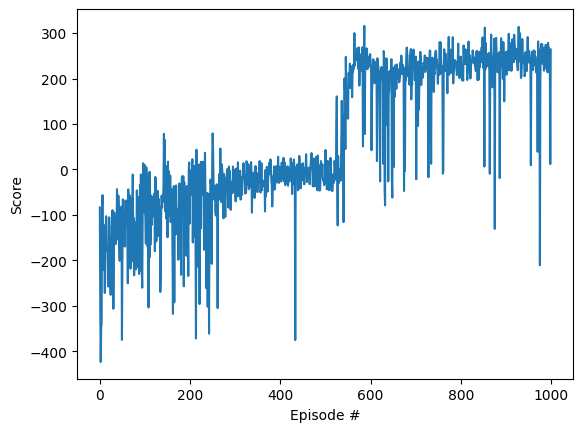

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

<font color='red'>**Please save the reward history plot and add it to your report.**</font>

Now let's render the result, 

Total reward: 257.43063934837676


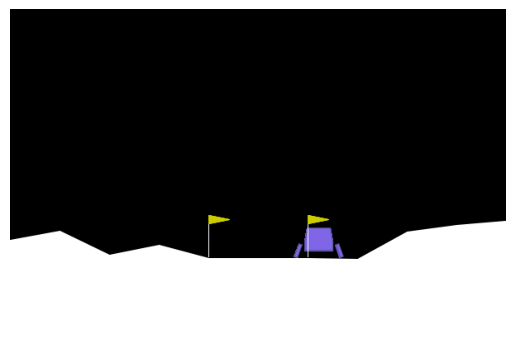

In [23]:
agent = Agent(state_size=8, action_size=4, seed=0)
state = env.reset()[0]
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
total_reward = 0
render = True
if render:
    img = plt.imshow(env.render())

while True:
    if render:
        img.set_data(env.render())
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
    action = env.action_space.sample()
    action = agent.act(state)
    state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break
print(f"Total reward: {total_reward}")

Congratulations, you just solved the Lunar Lander task! 

<font color='red'>**Please make a screen recording of the episode animation and report on the total reward.**</font>

You can play around with the parameter to get a feeling for how important these are for solving the task. You can also try to implement other RL algorithms.

<font color='red'>**Please make sure to save ALL cell outputs in Jupyter Notebook and add the file to your code archive.**</font> Do NOT clear cell outputs. Submission without cell outputs will be penalized up to half the points of the task.